<a href="https://colab.research.google.com/gist/qbeer/1df46c5028ad976dcf497f8117046830/hw9_raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [345]:
#!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn import metrics
import tensorflow as tf

/Users/barnabasp/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


## Neural networks, introduction


### 1. Implement a logistic regression model on MNIST for binary classification in Numpy

* use `from sklearn.datasets import load_digits`
  * the provided data files: X_train, X_test are a split generated by the author of this exercise
  * w, b are the fitted logistic regression weight and bias, the predictions on the provided test set can be generated by: `y_pred_test = sigmoid(np.dot(w, X_test.T) + b)`
  * the binarized accuracy score should be above 98% for this particular data
* divide the data into 0 vs. 1-9. categories
  * the goal is to separate the zeros
* y = logistic(wx + b)
* optimize the model via stochastic mini-batch gradient descent until you reach above 90% accuracy on the test set

* the loss:

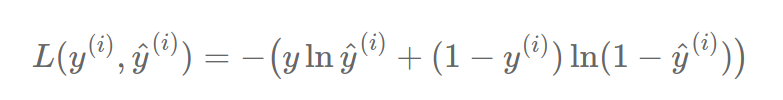

* the gradients of the mini-batch loss:

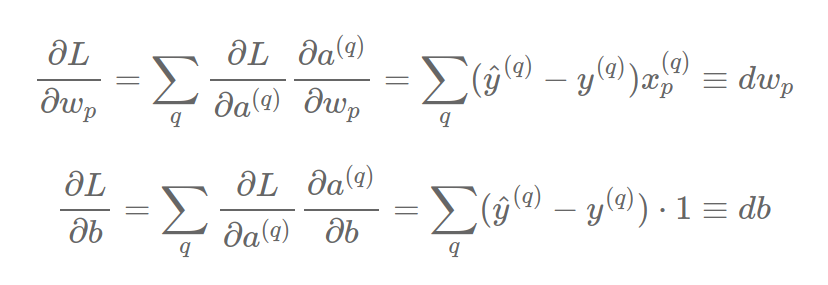

In [23]:
#Loading data
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
w = np.load('w.npy')
b = np.load('b.npy')

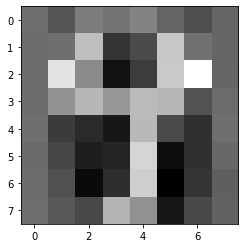

In [22]:
#to show whats in the data one can reshape
plt.imshow(X_test[1].reshape(8,8),cmap='gray')

In [78]:
def sigmoid(x):
    return 1/(1+np.e**(-x))
def predict(X,w,b):
    return sigmoid(np.dot(w, X.T) + b).T

#### Weighted

In [131]:
np.dot((predict(X_test,w,b) - y_test).T,X_test).shape

(1, 64)

#### B

In [133]:
np.dot((predict(X_test,w,b) - y_test).T,np.ones(shape=(predict(X_test,w,b) - y_test).shape)).shape

(1, 1)

#### Creating shuffle for stochastic

In [305]:
# HELP https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
def sMiniBatchGD(X,y,w,b, batch_s=10, iterations=1, learn_rate=1):
    for it in range(iterations):
        idx = [x for x in range(len(X))]
        random.shuffle(idx)
        X = X[idx]
        y = y[idx]
        l = len(y)
        batch_num = int(l/batch_s) # will leave out a few
#        print(l,batch_s,batch_num)
        B_b = []
        w_b = []
        for ibatch in range(batch_num):
            x_batch = X[ibatch*batch_s:(ibatch+1)*batch_s]
            y_batch = y[ibatch*batch_s:(ibatch+1)*batch_s]
            y_predict = predict(x_batch,w,b)
            factor = (y_predict - y_batch).T
            w_b.append(np.dot(factor,x_batch))
            B_b.append(np.dot(factor,np.ones((batch_s))))
        db = np.array(B_b).flatten().mean()
        dw = np.array(w_b).reshape(batch_num,X[0].shape[0]).mean(axis=0)
        b = b - db * learn_rate
        w = w - dw * learn_rate

    return w, b

In [324]:
w_gd, b_gd = sMiniBatchGD(X_train,y_train,w,b,batch_s=10, iterations=1)
y_pred = predict(X_test,w_gd, b_gd).round()

Text(0.5, 103.73999999999997, 'Predicted')

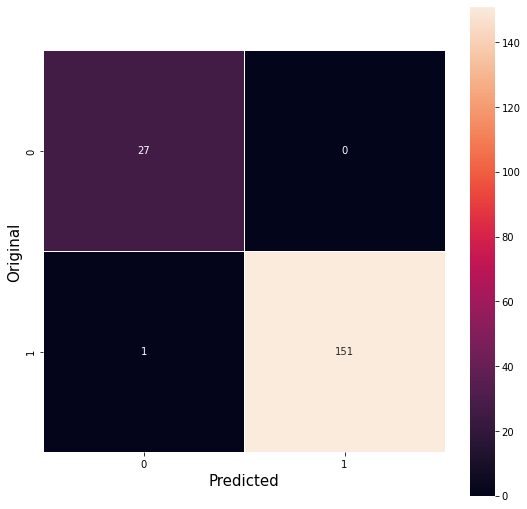

In [325]:
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, 
            annot=True,
            fmt="d",
            linewidths=.5,
            square = True)
plt.ylabel('Original',fontsize=15)
plt.xlabel('Predicted',fontsize=15)

It is quite obvious, the prediction is really good with only 1 iteration. It of course depends on the batch size as well, but for predicting if it is zero or not, it works like miracle

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]


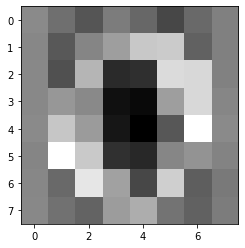

In [343]:
#looking at the first few
print(y_pred[0:5])
plt.imshow(X_test[2].reshape(8,8),cmap='gray')

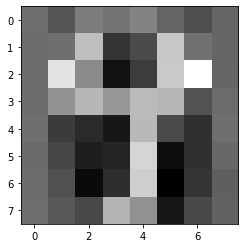

In [344]:
plt.imshow(X_test[1].reshape(8,8),cmap='gray')

### 2. MLP model in `tf.keras`

* implement a model as such:

 * 750 neuron, relu activation
 * 500 neuron, relu activation
 * 500 neuron, relu activation
 * 10 neuron, softmax activation

* use the `tf.keras.datasets.mnist` dataset in this case
* preprocess if necessary
* use the 'sgd' optimizer, log the loss ('categorical_crossentropy') and the accuracy, as well as the AUC score during training, visualize the history of these values

from https://patbaa.web.elte.hu/physdm/code_examples/fully_connected.html

In [346]:
tf.keras.datasets.mnist

<module 'keras.api._v2.keras.datasets.mnist' from '/Users/barnabasp/opt/anaconda3/lib/python3.7/site-packages/keras/api/_v2/keras/datasets/mnist/__init__.py'>

### 3. Evaluation

* confusion matrix on the test set
* visualize mistakes (at least 16) in a grid, show the true and the predicted labels
* plot the ROC curve for each predicted class

### 4. Come up with your own model

* come up with your own small model (< 100'000 neurons)
* train it for 50 epochs
* visualize the loss for train/test on the same plot
  * what are your thoughs on the phenomenon?
* plot the ROC curves and the AUC scores

### 5. Experiment with the CIFAR10 dataset

* preprocess the data, modify the models accordingly
  * train your small model as well as the model in the 3rd task on the CIFAR10 dataset
* compare the results
* are these models powerful enough to fit this data?


Hints:
On total you can get 10 points for fully completing all tasks.
Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
Comments you code when necessary
Write functions for repetitive tasks!
Use the pandas package for data loading and handling
Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
Use the scikit learn package for almost everything
Use for loops only if it is really necessary!
Code sharing is not allowed between student! Sharing code will result in zero points.
If you use code found on web, it is OK, but, make its source clear!